# Heart Disease Classification with Neural Network

## 1. Import Libraries

In [1]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

### 1.1 Seed Configuration

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## 2. Load Dataset

In [3]:
DATA_PATH = "heart.csv"
TARGET_COL = "HeartDisease"

In [4]:
print("\n Loading Data...")

df = pd.read_csv(DATA_PATH)
df


 Loading Data...


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 2.1 Feature Type Definition

In [5]:
NUMERIC_COLS = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
CATEGORICAL_COLS = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS"]

df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype("category")

### 2.2 Data Overview

In [6]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [7]:
for col in CATEGORICAL_COLS:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")


Unique values in 'Sex': 2

Unique values in 'ChestPainType': 4

Unique values in 'RestingECG': 3

Unique values in 'ExerciseAngina': 2

Unique values in 'ST_Slope': 3

Unique values in 'FastingBS': 2


In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
df.duplicated().sum()

0

## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [10]:
print("EXPLORATORY DATA ANALYSIS")
print(f"\nData info:")
print(df.info())

EXPLORATORY DATA ANALYSIS

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB
None


### 3.2 Target Distribution


 Distribusi Variabel 
----------------------------------------------------------------------

Class 0 (No Disease):   410 samples (44.66%)
Class 1 (Disease):      508 samples (55.34%)
Imbalance Ratio:      1.239


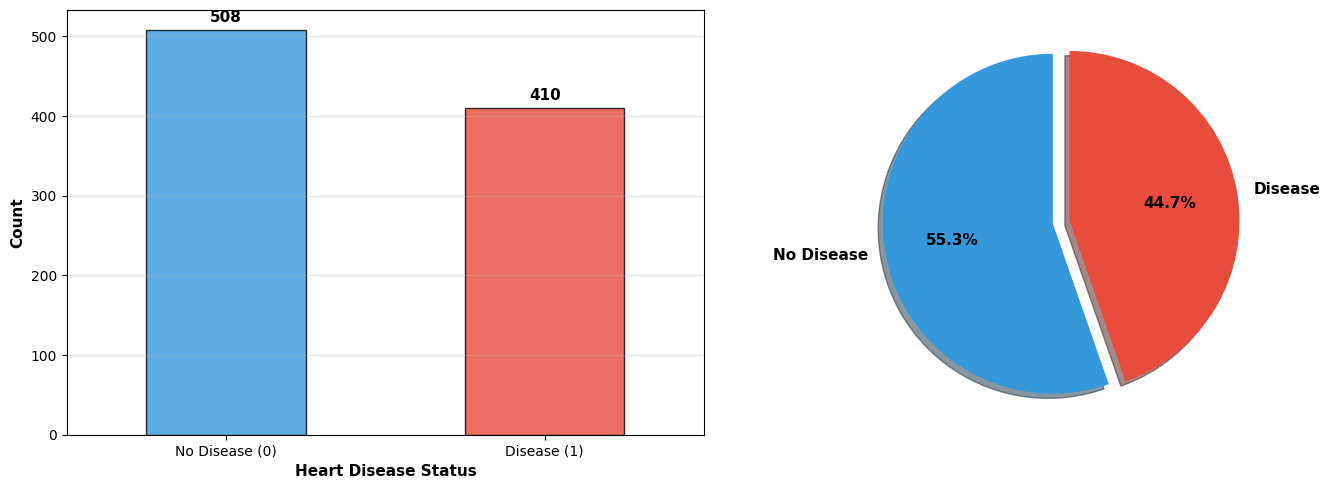

In [11]:
print("\n Distribusi Variabel ")
print("-"*70)

target_counts = df[TARGET_COL].value_counts()
target_pct = df[TARGET_COL].value_counts(normalize=True) * 100

print(f"\nClass 0 (No Disease): {target_counts[0]:>5} samples ({target_pct[0]:.2f}%)")
print(f"Class 1 (Disease):    {target_counts[1]:>5} samples ({target_pct[1]:.2f}%)")
print(f"Imbalance Ratio:      {target_counts[1] / target_counts[0]:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#3498db', '#e74c3c']
target_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Heart Disease Status', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(target_counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=11)

axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05), shadow=True,
            textprops={'fontsize': 11, 'fontweight': 'bold'})

plt.tight_layout()
plt.show()

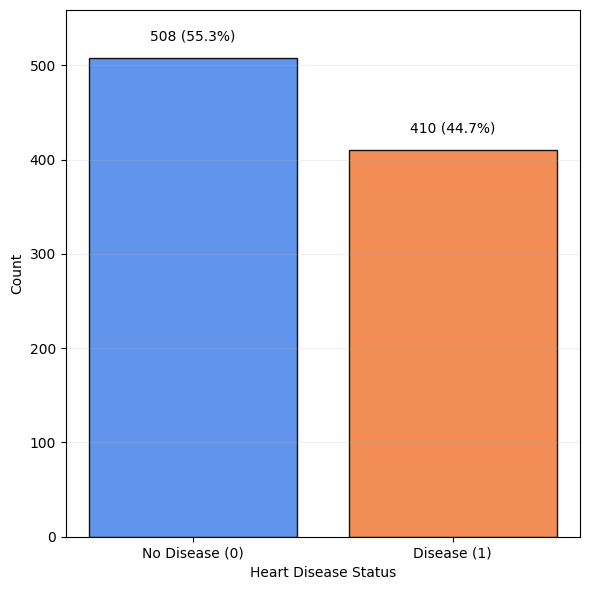

In [12]:
import matplotlib.pyplot as plt

# =====================
# BAR CHART DENGAN FORMAT: 50 (50%)
# =====================

fig, ax = plt.subplots(figsize=(6, 6))

colors = ["#508AE9", "#F18242"]

total = target_counts.values.sum()

bars = ax.bar(
    ['No Disease (0)', 'Disease (1)'],
    target_counts.values,
    color=colors,
    edgecolor='black',
    alpha=0.9
)

ax.set_xlabel('Heart Disease Status', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.grid(axis='y', alpha=0.2)

# Supaya label tidak menabrak batas atas
ax.set_ylim(0, max(target_counts.values) * 1.1)

# Label: jumlah (persentase)
for bar, value in zip(bars, target_counts.values):
    percent = (value / total) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        value + max(target_counts.values) * 0.03,
        f'{int(value)} ({percent:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


### 3.4 Feature Distribution


Distribusi Variabel Numerik


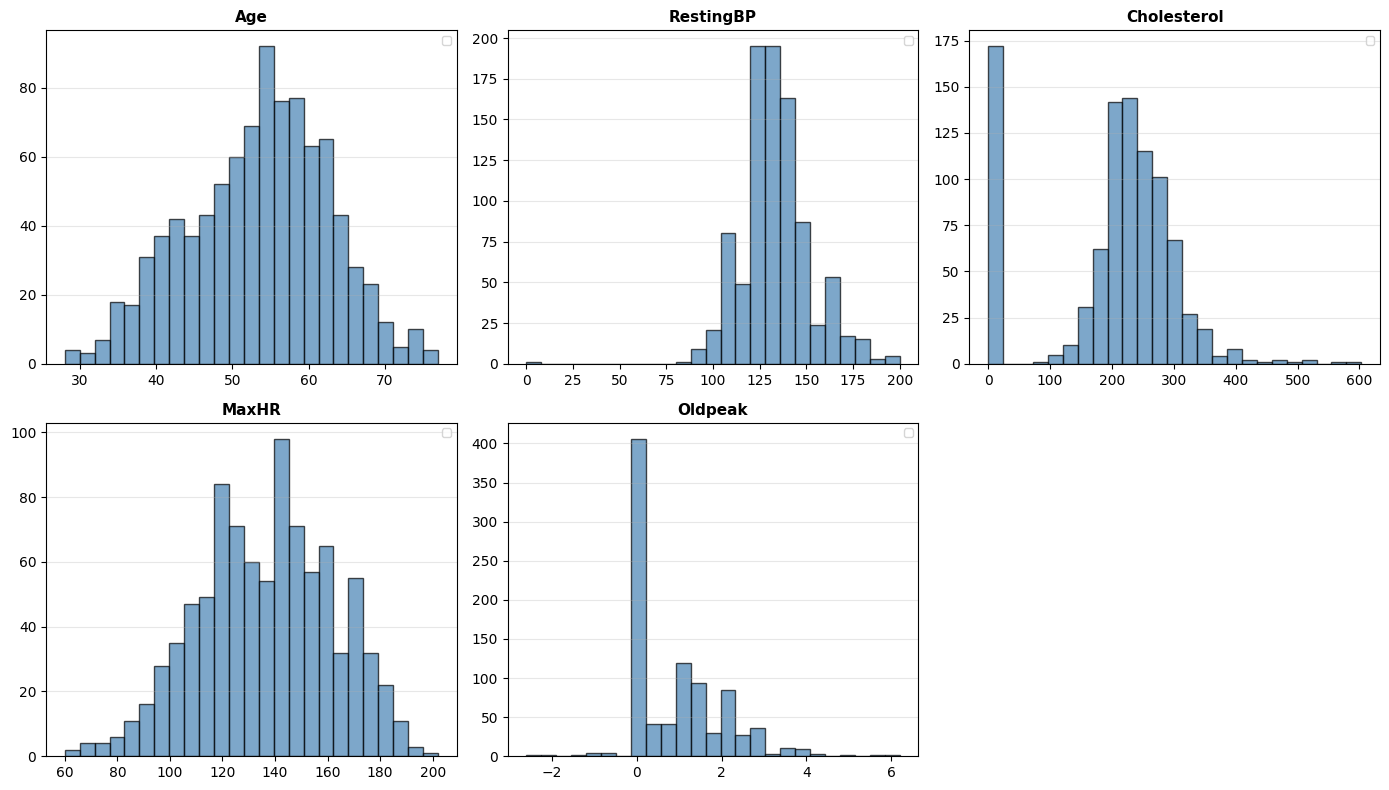


Distribusi Variabel Kategorikal


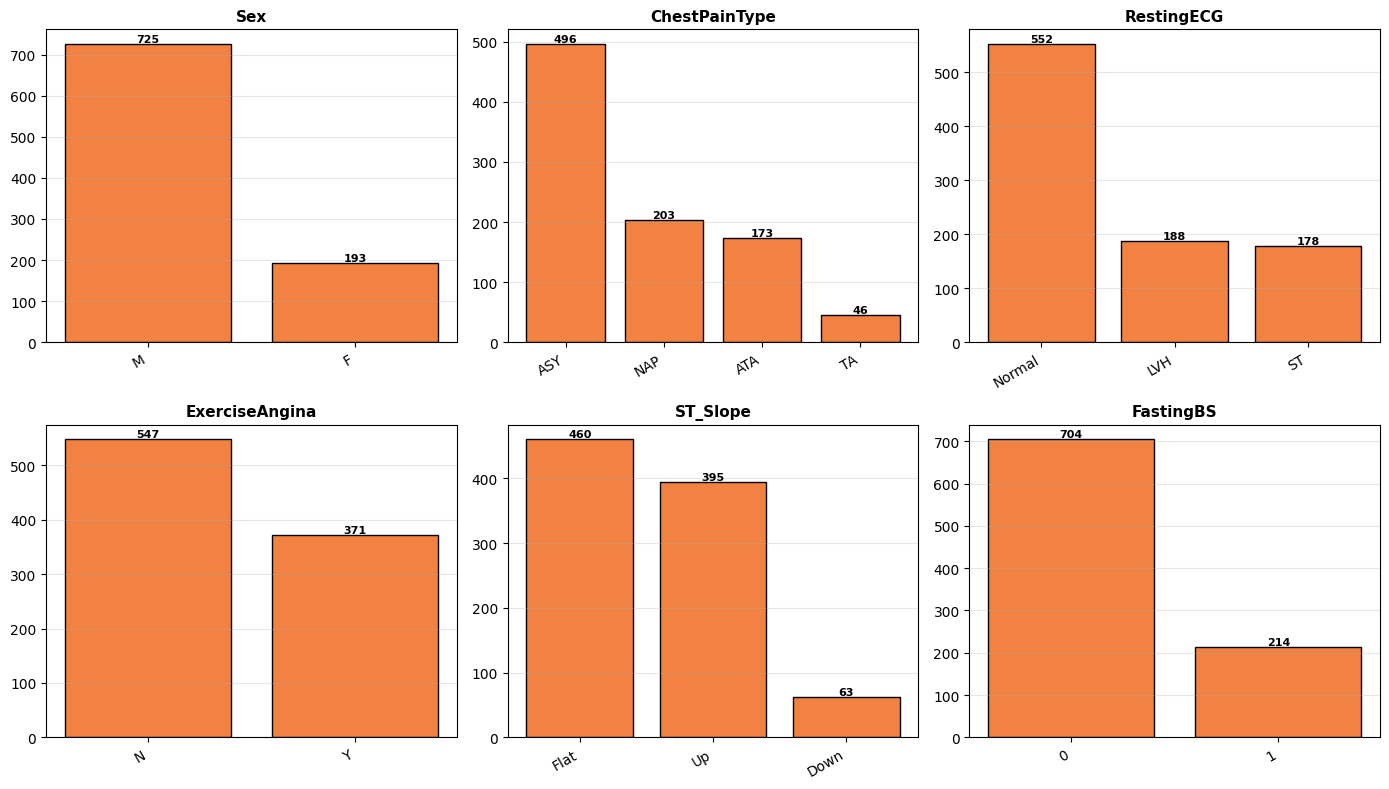

In [13]:
print("\nDistribusi Variabel Numerik")
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_COLS):
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].hist(df[col], bins=25, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(axis='y', alpha=0.3)

if len(NUMERIC_COLS) < len(axes):
    for j in range(len(NUMERIC_COLS), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

print("\nDistribusi Variabel Kategorikal")
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(CATEGORICAL_COLS):
    counts = df[col].value_counts()
    axes[i].bar(counts.index.astype(str), counts.values, color='#F18242', edgecolor='black')
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xticks(range(len(counts)))
    axes[i].set_xticklabels(counts.index, rotation=30, ha='right')
    axes[i].grid(axis='y', alpha=0.3)
    for x, y in enumerate(counts.values):
        axes[i].text(x, y, str(int(y)), ha='center', va='bottom', fontsize=8, fontweight='bold')

if len(CATEGORICAL_COLS) < len(axes):
    for j in range(len(CATEGORICAL_COLS), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis


Analisis Korelasi
----------------------------------------------------------------------

Correlation with Target Variable (All Features):
HeartDisease      1.000000
ExerciseAngina    0.494282
Oldpeak           0.403951
Sex               0.305445
Age               0.282039
FastingBS         0.267291
RestingBP         0.107589
RestingECG        0.057384
Cholesterol      -0.232741
ChestPainType    -0.386828
MaxHR            -0.400421
ST_Slope         -0.558771


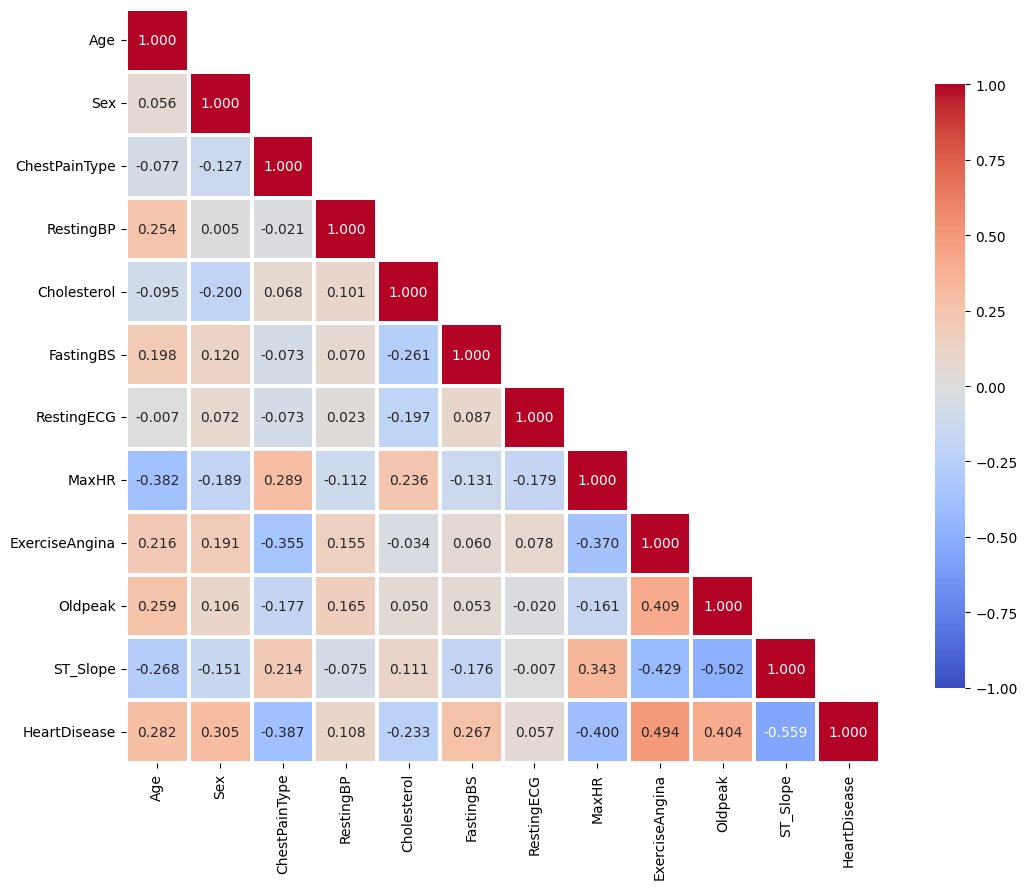

In [14]:
print("\nAnalisis Korelasi")
print("-"*70)

# Convert semua kolom kategorikal menjadi numerik
df_corr = df.copy()
for col in df_corr.columns:
    if df_corr[col].dtype == 'object' or df_corr[col].dtype.name == 'category':
        df_corr[col] = df_corr[col].astype('category').cat.codes

corr_matrix = df_corr.corr()

# Korelasi dengan target
target_corr = corr_matrix[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation with Target Variable (All Features):")
print(target_corr.to_string())

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.tight_layout()
plt.show()


## 4. Fitur dan Target

In [15]:
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found!"
y = df[TARGET_COL].astype(int).values
X = df.drop(columns=[TARGET_COL])

## 5. Data Preprocessing

In [16]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), NUMERIC_COLS),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_COLS)
], remainder="drop")

## 6. Model

In [17]:
from tensorflow.keras.layers import Dropout

LR_ADAM = 0.001
BATCH_SIZE = 64
EPOCHS = 100
n_features = X.shape[1] 

In [18]:
from tensorflow.keras.optimizers import SGD

LR_SGD = 0.01
MOMENTUM_SGD = 1

## 7. K-Fold Cross-Validation

### 7.1 Cross-Validation Setup

In [19]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD

# Set parameters untuk K-Fold
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Kombinasikan X dan y untuk K-Fold
X_combined = X
y_combined = y

print(f"\nTotal sample: {len(X_combined)}")
print(f"Folds: {n_splits}")
print(f"Ukuran Tiap Fold: ~{len(X_combined) // n_splits} samples\n")



Total sample: 918
Folds: 5
Ukuran Tiap Fold: ~183 samples



In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# Tambahkan penyimpanan history
all_history_adam = []
all_history_sgd = []

# Struktur hasil
cv_results_adam = {
    'fold': [],

    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],

    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],

    'runtime': []
}

cv_results_sgd = {
    'fold': [],

    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],

    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],

    'runtime': []
}

fold_idx = 1

for train_idx, test_idx in kfold.split(X_combined):
    print(f"\n{'='*70}")
    print(f"[FOLD {fold_idx}/{n_splits}]")
    print(f"{'='*70}")

    # Split data
    X_train_fold_raw = X_combined.iloc[train_idx] if hasattr(X_combined,'iloc') else X_combined[train_idx]
    y_train_fold      = y_combined[train_idx]
    X_test_fold_raw   = X_combined.iloc[test_idx] if hasattr(X_combined,'iloc') else X_combined[test_idx]
    y_test_fold       = y_combined[test_idx]

    print(f"Train: {len(X_train_fold_raw)} | Test: {len(X_test_fold_raw)}")

    # Preprocessing fit hanya pada train
    preprocess.fit(X_train_fold_raw)
    X_train_fold = preprocess.transform(X_train_fold_raw)
    X_test_fold  = preprocess.transform(X_test_fold_raw)

    n_features = X_train_fold.shape[1]

    early_stop = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # ==========================
    # 1. ADAM
    # ==========================
    print("\nRunning Adam...")

    model_adam = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        # Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model_adam.compile(
        optimizer=Adam(learning_rate=LR_ADAM),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    adam_start = time.time()
    history_adam = model_adam.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop]
    ).history
    adam_runtime = time.time() - adam_start

    # Simpan history
    all_history_adam.append(history_adam)
    
    # METRIK TRAIN
    y_prob_train = model_adam.predict(X_train_fold, verbose=0).flatten()
    y_pred_train = (y_prob_train > 0.5).astype(int)

    train_acc = accuracy_score(y_train_fold, y_pred_train)
    train_prec = precision_score(y_train_fold, y_pred_train, zero_division=0)
    train_rec = recall_score(y_train_fold, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train_fold, y_pred_train, zero_division=0)

    # METRIK TEST
    y_prob_test = model_adam.predict(X_test_fold, verbose=0).flatten()
    y_pred_test = (y_prob_test > 0.5).astype(int)

    test_acc = accuracy_score(y_test_fold, y_pred_test)
    test_prec = precision_score(y_test_fold, y_pred_test, zero_division=0)
    test_rec = recall_score(y_test_fold, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_test_fold, y_pred_test, zero_division=0)

    cv_results_adam['fold'].append(fold_idx)
    cv_results_adam['train_accuracy'].append(train_acc)
    cv_results_adam['train_precision'].append(train_prec)
    cv_results_adam['train_recall'].append(train_rec)
    cv_results_adam['train_f1'].append(train_f1)

    cv_results_adam['test_accuracy'].append(test_acc)
    cv_results_adam['test_precision'].append(test_prec)
    cv_results_adam['test_recall'].append(test_rec)
    cv_results_adam['test_f1'].append(test_f1)

    cv_results_adam['runtime'].append(adam_runtime)

    print(f"Adam Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {adam_runtime:.2f}s")


    # ==========================
    # 2. SGD
    # ==========================
    print("Running SGD...")

    model_sgd = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        # Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_sgd.compile(
        optimizer=SGD(learning_rate=LR_SGD),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    sgd_start = time.time()
    history_sgd = model_sgd.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop]
    ).history
    sgd_runtime = time.time() - sgd_start

    # Simpan history
    all_history_sgd.append(history_sgd)

    # TRAIN
    y_prob_train = model_sgd.predict(X_train_fold, verbose=0).flatten()
    y_pred_train = (y_prob_train > 0.5).astype(int)

    train_acc = accuracy_score(y_train_fold, y_pred_train)
    train_prec = precision_score(y_train_fold, y_pred_train, zero_division=0)
    train_rec = recall_score(y_train_fold, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train_fold, y_pred_train, zero_division=0)

    # TEST
    y_prob_test = model_sgd.predict(X_test_fold, verbose=0).flatten()
    y_pred_test = (y_prob_test > 0.5).astype(int)

    test_acc = accuracy_score(y_test_fold, y_pred_test)
    test_prec = precision_score(y_test_fold, y_pred_test, zero_division=0)
    test_rec = recall_score(y_test_fold, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_test_fold, y_pred_test, zero_division=0)

    cv_results_sgd['fold'].append(fold_idx)
    cv_results_sgd['train_accuracy'].append(train_acc)
    cv_results_sgd['train_precision'].append(train_prec)
    cv_results_sgd['train_recall'].append(train_rec)
    cv_results_sgd['train_f1'].append(train_f1)

    cv_results_sgd['test_accuracy'].append(test_acc)
    cv_results_sgd['test_precision'].append(test_prec)
    cv_results_sgd['test_recall'].append(test_rec)
    cv_results_sgd['test_f1'].append(test_f1)

    cv_results_sgd['runtime'].append(sgd_runtime)

    print(f"SGD Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {sgd_runtime:.2f}s")

    fold_idx += 1


[FOLD 1/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 1.0000 | Test Acc: 0.8696 | Time: 5.19s
Running SGD...
SGD Train Acc: 0.8815 | Test Acc: 0.8696 | Time: 4.63s

[FOLD 2/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 0.9973 | Test Acc: 0.8315 | Time: 5.08s
Running SGD...
SGD Train Acc: 0.8828 | Test Acc: 0.8859 | Time: 4.62s

[FOLD 3/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 0.9986 | Test Acc: 0.8696 | Time: 5.02s
Running SGD...
SGD Train Acc: 0.8747 | Test Acc: 0.8913 | Time: 4.64s

[FOLD 4/5]
Train: 735 | Test: 183

Running Adam...
Adam Train Acc: 0.9986 | Test Acc: 0.7814 | Time: 5.06s
Running SGD...
SGD Train Acc: 0.8939 | Test Acc: 0.8197 | Time: 4.64s

[FOLD 5/5]
Train: 735 | Test: 183

Running Adam...
Adam Train Acc: 0.9973 | Test Acc: 0.8525 | Time: 5.35s
Running SGD...
SGD Train Acc: 0.8776 | Test Acc: 0.8525 | Time: 4.68s


In [21]:
model_sgd.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,139 (43.52 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [22]:
model_adam.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,413 (130.52 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,276 (87.02 KB)

### 7.2 Cross-Validation Results Summary

In [23]:
df_cv_adam = pd.DataFrame(cv_results_adam)
df_cv_sgd = pd.DataFrame(cv_results_sgd)

summary_adam = {
    'Optimizer': 'Adam',
    'Accuracy': f"{df_cv_adam['test_accuracy'].mean():.4f} ± {df_cv_adam['test_accuracy'].std():.4f}",
    'Precision': f"{df_cv_adam['test_precision'].mean():.4f} ± {df_cv_adam['test_precision'].std():.4f}",
    'Recall': f"{df_cv_adam['test_recall'].mean():.4f} ± {df_cv_adam['test_recall'].std():.4f}",
    'F1-Score': f"{df_cv_adam['test_f1'].mean():.4f} ± {df_cv_adam['test_f1'].std():.4f}",
    'Runtime': f"{df_cv_adam['runtime'].mean():.2f}s ± {df_cv_adam['runtime'].std():.2f}s"
}

summary_sgd = {
    'Optimizer': 'SGD',
    'Accuracy': f"{df_cv_sgd['test_accuracy'].mean():.4f} ± {df_cv_sgd['test_accuracy'].std():.4f}",
    'Precision': f"{df_cv_sgd['test_precision'].mean():.4f} ± {df_cv_sgd['test_precision'].std():.4f}",
    'Recall': f"{df_cv_sgd['test_recall'].mean():.4f} ± {df_cv_sgd['test_recall'].std():.4f}",
    'F1-Score': f"{df_cv_sgd['test_f1'].mean():.4f} ± {df_cv_sgd['test_f1'].std():.4f}",
    'Runtime': f"{df_cv_sgd['runtime'].mean():.2f}s ± {df_cv_sgd['runtime'].std():.2f}s"
}

print("\n[8.3] CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)
print("\nPER FOLD RESULTS - ADAM:")
print("-"*70)
print(df_cv_adam.to_string(index=False))

print("\n\nPER FOLD RESULTS - SGD:")
print("-"*70)
print(df_cv_sgd.to_string(index=False))



[8.3] CROSS-VALIDATION RESULTS SUMMARY

PER FOLD RESULTS - ADAM:
----------------------------------------------------------------------
 fold  train_accuracy  train_precision  train_recall  train_f1  test_accuracy  test_precision  test_recall  test_f1  runtime
    1        1.000000         1.000000      1.000000  1.000000       0.869565        0.919192     0.850467 0.883495 5.188806
    2        0.997275         0.997462      0.997462  0.997462       0.831522        0.902913     0.815789 0.857143 5.079912
    3        0.998638         0.997579      1.000000  0.998788       0.869565        0.852941     0.906250 0.878788 5.021476
    4        0.998639         0.997561      1.000000  0.998779       0.781421        0.780952     0.828283 0.803922 5.056486
    5        0.997279         0.997596      0.997596  0.997596       0.852459        0.803738     0.934783 0.864322 5.345920


PER FOLD RESULTS - SGD:
----------------------------------------------------------------------
 fold  train_acc

In [24]:
print("\nTABEL HASIL CV - SGD")
print("="*70)
print(f"{'METRIK':15} | {'TRAIN':17} | {'TEST':17}")
print("-"*70)
print(f"{'Accuracy':15} | {df_cv_sgd['train_accuracy'].mean():.4f} ± {df_cv_sgd['train_accuracy'].std():.4f}   | {summary_sgd['Accuracy']}")
print(f"{'Precision':15} | {df_cv_sgd['train_precision'].mean():.4f} ± {df_cv_sgd['train_precision'].std():.4f}   | {summary_sgd['Precision']}")
print(f"{'Recall':15} | {df_cv_sgd['train_recall'].mean():.4f} ± {df_cv_sgd['train_recall'].std():.4f}   | {summary_sgd['Recall']}")
print(f"{'F1 Score':15} | {df_cv_sgd['train_f1'].mean():.4f} ± {df_cv_sgd['train_f1'].std():.4f}   | {summary_sgd['F1-Score']}")
print(f"{'Runtime':15} | {'-':17} | {summary_sgd['Runtime']}")

print("\nTABEL HASIL CV - ADAM")
print("="*70)
print(f"{'METRIK':15} | {'TRAIN':17} | {'TEST':17}")
print("-"*70)
print(f"{'Accuracy':15} | {df_cv_adam['train_accuracy'].mean():.4f} ± {df_cv_adam['train_accuracy'].std():.4f}   | {summary_adam['Accuracy']}")
print(f"{'Precision':15} | {df_cv_adam['train_precision'].mean():.4f} ± {df_cv_adam['train_precision'].std():.4f}   | {summary_adam['Precision']}")
print(f"{'Recall':15} | {df_cv_adam['train_recall'].mean():.4f} ± {df_cv_adam['train_recall'].std():.4f}   | {summary_adam['Recall']}")
print(f"{'F1 Score':15} | {df_cv_adam['train_f1'].mean():.4f} ± {df_cv_adam['train_f1'].std():.4f}   | {summary_adam['F1-Score']}")
print(f"{'Runtime':15} | {'-':17} | {summary_adam['Runtime']}")


TABEL HASIL CV - SGD
METRIK          | TRAIN             | TEST             
----------------------------------------------------------------------
Accuracy        | 0.8821 ± 0.0073   | 0.8638 ± 0.0290
Precision       | 0.8795 ± 0.0100   | 0.8650 ± 0.0552
Recall          | 0.9120 ± 0.0068   | 0.8952 ± 0.0357
F1 Score        | 0.8954 ± 0.0060   | 0.8785 ± 0.0275
Runtime         | -                 | 4.64s ± 0.02s

TABEL HASIL CV - ADAM
METRIK          | TRAIN             | TEST             
----------------------------------------------------------------------
Accuracy        | 0.9984 ± 0.0011   | 0.8409 ± 0.0368
Precision       | 0.9980 ± 0.0011   | 0.8519 ± 0.0602
Recall          | 0.9990 ± 0.0014   | 0.8671 ± 0.0513
F1 Score        | 0.9985 ± 0.0010   | 0.8575 ± 0.0318
Runtime         | -                 | 5.14s ± 0.13s


In [25]:
test_adam = {
    'Optimizer': 'Adam',
    'Accuracy': f"{df_cv_adam['test_accuracy'].mean():.4f}",
    'Precision': f"{df_cv_adam['test_precision'].mean():.4f}",
    'Recall': f"{df_cv_adam['test_recall'].mean():.4f}",
    'F1-Score': f"{df_cv_adam['test_f1'].mean():.4f}",
    'Runtime': f"{df_cv_adam['runtime'].mean():.2f}s"
}

test_sgd = {
    'Optimizer': 'SGD',
    'Accuracy': f"{df_cv_sgd['test_accuracy'].mean():.4f}",
    'Precision': f"{df_cv_sgd['test_precision'].mean():.4f}",
    'Recall': f"{df_cv_sgd['test_recall'].mean():.4f}",
    'F1-Score': f"{df_cv_sgd['test_f1'].mean():.4f}",
    'Runtime': f"{df_cv_sgd['runtime'].mean():.2f}s"
}

In [26]:
print("\nTABEL HASIL CV - SGD")
print("="*40)
print(f"{'METRIK':15} | {'TRAIN':6} | {'TEST':17}")
print("-"*40)
print(f"{'Accuracy':15} | {df_cv_sgd['train_accuracy'].mean():.4f} | {test_sgd['Accuracy']}")
print(f"{'Precision':15} | {df_cv_sgd['train_precision'].mean():.4f} | {test_sgd['Precision']}")
print(f"{'Recall':15} | {df_cv_sgd['train_recall'].mean():.4f} | {test_sgd['Recall']}")
print(f"{'F1 Score':15} | {df_cv_sgd['train_f1'].mean():.4f} | {test_sgd['F1-Score']}")
print(f"{'Runtime':15} | {'-':6} | {test_sgd['Runtime']}")
print("\nTABEL HASIL CV - ADAM")
print("="*40)
print(f"{'METRIK':15} | {'TRAIN':6} | {'TEST':17}")
print("-"*40)
print(f"{'Accuracy':15} | {df_cv_adam['train_accuracy'].mean():.4f} | {test_adam['Accuracy']}")
print(f"{'Precision':15} | {df_cv_adam['train_precision'].mean():.4f} | {test_adam['Precision']}")
print(f"{'Recall':15} | {df_cv_adam['train_recall'].mean():.4f} | {test_adam['Recall']}")
print(f"{'F1 Score':15} | {df_cv_adam['train_f1'].mean():.4f} | {test_adam['F1-Score']}")
print(f"{'Runtime':15} | {'-':6} | {test_adam['Runtime']}")


TABEL HASIL CV - SGD
METRIK          | TRAIN  | TEST             
----------------------------------------
Accuracy        | 0.8821 | 0.8638
Precision       | 0.8795 | 0.8650
Recall          | 0.9120 | 0.8952
F1 Score        | 0.8954 | 0.8785
Runtime         | -      | 4.64s

TABEL HASIL CV - ADAM
METRIK          | TRAIN  | TEST             
----------------------------------------
Accuracy        | 0.9984 | 0.8409
Precision       | 0.9980 | 0.8519
Recall          | 0.9990 | 0.8671
F1 Score        | 0.9985 | 0.8575
Runtime         | -      | 5.14s


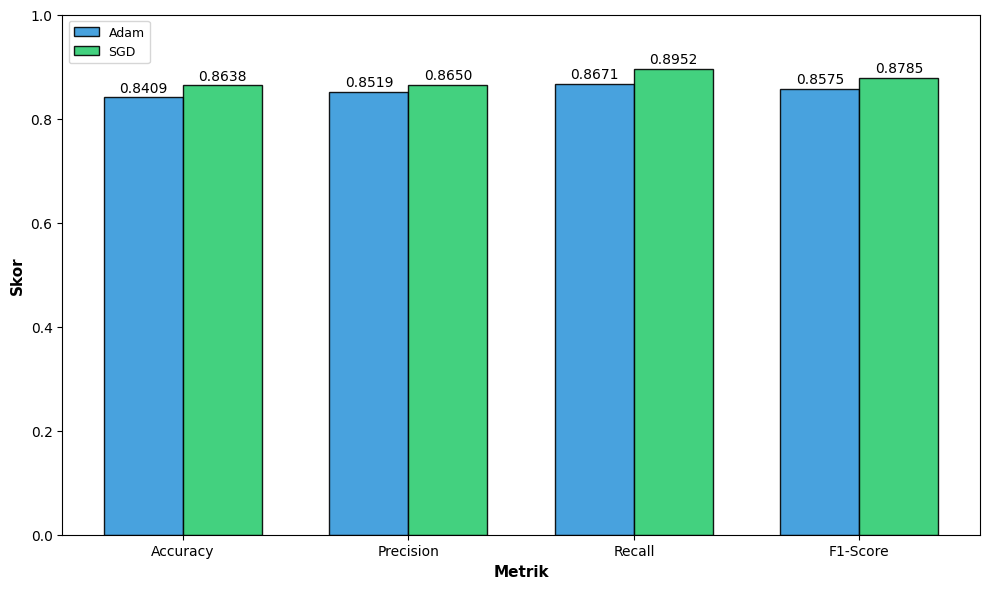

In [27]:
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

adam_means = [df_cv_adam[m].mean() for m in metrics]
sgd_means  = [df_cv_sgd[m].mean()  for m in metrics]

plt.figure(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35


plt.bar(x - width/2, adam_means, width, label='Adam', color='#3498db', edgecolor='black', alpha=0.9)
plt.bar(x + width/2, sgd_means,  width, label='SGD',  color='#2ecc71', edgecolor='black', alpha=0.9)

plt.xlabel('Metrik', fontsize=11, fontweight='bold')
plt.ylabel('Skor', fontsize=11, fontweight='bold')
plt.xticks(x, metric_labels, rotation=0)
plt.ylim(0, 1.0)
plt.legend(fontsize=9)

for i, (adam_val, sgd_val) in enumerate(zip(adam_means, sgd_means)):
    plt.text(i - width/2, adam_val + 0.005, f'{adam_val:.4f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2,  sgd_val + 0.005,  f'{sgd_val:.4f}',  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()